In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
from array import *
import itertools
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [2]:
# Reading the training data
train_data = pd.read_csv("train_df.csv")
train_data.head()

record_ID        week  store_id  sku_id  total_price  base_price  \
0          1  17-01-2011      8091  216418      99.0375    111.8625   
1          2  17-01-2011      8091  216419      99.0375     99.0375   
2          3  17-01-2011      8091  216425     133.9500    133.9500   
3          4  17-01-2011      8091  216233     133.9500    133.9500   
4          5  17-01-2011      8091  217390     141.0750    141.0750   

   is_featured_sku  is_display_sku  units_sold  
0                0               0          20  
1                0               0          28  
2                0               0          19  
3                0               0          44  
4                0               0          52

No. of unique records: 150150
No. of unique store ids: 76
No. of unique SKU ids: 28
Total number of featured units: 14356
Total number of displayed units: 20000


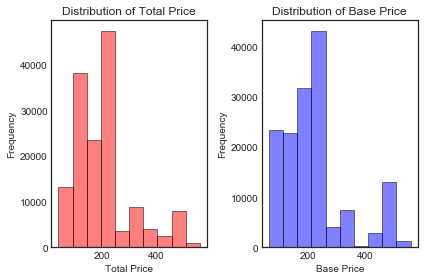

Correlation between Total price and Base price: 0.959


Maximum number of units sold: 2876


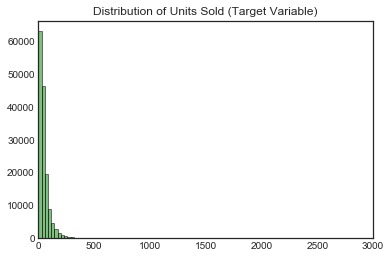

In [3]:
# Exploring the data
print("No. of unique records:", len(np.unique(train_data.record_ID)))
print("No. of unique store ids:", len(np.unique(train_data.store_id)))
print("No. of unique SKU ids:", len(np.unique(train_data.sku_id)))
print("Total number of featured units:", np.sum(train_data.is_featured_sku))
print("Total number of displayed units:", np.sum(train_data.is_display_sku))

fig, ax = plt.subplots(1,2)
ax[0].hist(train_data.total_price, alpha = 0.5, color = "r", edgecolor = "black")
ax[0].set_title("Distribution of Total Price")
ax[0].set_xlabel("Total Price")
ax[0].set_ylabel("Frequency")
ax[1].hist(train_data.base_price, alpha = 0.5, color = "b", edgecolor = "black")
ax[1].set_title("Distribution of Base Price")
ax[1].set_xlabel("Base Price")
ax[1].set_ylabel("Frequency")
fig.tight_layout()
plt.show()

from scipy.stats import pearsonr
corr, _ = pearsonr(train_data.total_price, train_data.base_price)
print("Correlation between Total price and Base price: %.3f" % corr)

print("\n\nMaximum number of units sold:", np.max(train_data.units_sold))
plt.hist(train_data.units_sold, bins = 100, color = "g", alpha = 0.5, edgecolor = "black")
plt.title("Distribution of Units Sold (Target Variable)")
plt.xlim(0,3000);

#### Key takeaways from the exploration of data
1. Number of unique SKUs and stores is low, indicating a possibility of creating models particular to each SKU-store combination for better prediction
2. Correlation between Total price and Base price is extremely high, so one of them can be removed to avoid multicollinearity
3. Certain records have extremely high number of units sold

In [4]:
# Creating additional features 
train_data.week = [datetime.strptime(item,'%d-%m-%Y') for item in train_data.week]
train_data['year'] = [item.year for item in train_data.week]
train_data['month'] = [item.month for item in train_data.week]
train_data['price_diff'] = train_data.total_price - train_data.base_price
train_data['feat_disp'] = train_data.is_featured_sku.astype(int) + train_data.is_display_sku.astype(int)
train_data.head()

record_ID       week  store_id  sku_id  total_price  base_price  \
0          1 2011-01-17      8091  216418      99.0375    111.8625   
1          2 2011-01-17      8091  216419      99.0375     99.0375   
2          3 2011-01-17      8091  216425     133.9500    133.9500   
3          4 2011-01-17      8091  216233     133.9500    133.9500   
4          5 2011-01-17      8091  217390     141.0750    141.0750   

   is_featured_sku  is_display_sku  units_sold  year  month  price_diff  \
0                0               0          20  2011      1     -12.825   
1                0               0          28  2011      1       0.000   
2                0               0          19  2011      1       0.000   
3                0               0          44  2011      1       0.000   
4                0               0          52  2011      1       0.000   

   feat_disp  
0          0  
1          0  
2          0  
3          0  
4          0

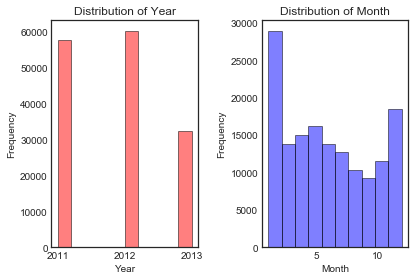

In [5]:
fig, ax = plt.subplots(1,2)
ax[0].hist(train_data.year, alpha = 0.5, color = "r", edgecolor = "black")
ax[0].set_title("Distribution of Year")
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Frequency")
ax[1].hist(train_data.month, alpha = 0.5, color = "b", edgecolor = "black")
ax[1].set_title("Distribution of Month")
ax[1].set_xlabel("Month")
ax[1].set_ylabel("Frequency")
fig.tight_layout()
plt.show()

In [6]:
# Creating one-hot encoding variables for year and month
dummy_variables = [pd.get_dummies(train_data['year'], prefix = 'year', prefix_sep = ':'),
                 pd.get_dummies(train_data['month'], prefix = 'month', prefix_sep = ':')]
dummy_variables = pd.concat(dummy_variables, axis = 1)
train_data = pd.concat([train_data, dummy_variables], axis = 1)

# Dropping unnecessary columns
train_data.drop(['record_ID', 'week', 'year', 'month'], axis = 1, inplace = True)
train_data.head()

store_id  sku_id  total_price  base_price  is_featured_sku  is_display_sku  \
0      8091  216418      99.0375    111.8625                0               0   
1      8091  216419      99.0375     99.0375                0               0   
2      8091  216425     133.9500    133.9500                0               0   
3      8091  216233     133.9500    133.9500                0               0   
4      8091  217390     141.0750    141.0750                0               0   

   units_sold  price_diff  feat_disp  year:2011  ...  month:3  month:4  \
0          20     -12.825          0          1  ...        0        0   
1          28       0.000          0          1  ...        0        0   
2          19       0.000          0          1  ...        0        0   
3          44       0.000          0          1  ...        0        0   
4          52       0.000          0          1  ...        0        0   

   month:5  month:6  month:7  month:8  month:9  month:10  month:11  month:12  
0        0        0        0        0        0         0         0         0  
1        0        0        0        0        0         0         0         0  
2        0        0        0        0        0         0         0         0  
3        0        0        0        0        0         0         0         0  
4        0        0        0        0        0         0         0         0  

[5 rows x 24 columns]

In [7]:
# Making the same changes to the test dataset
test_data = pd.read_csv("test_df.csv")
test_data.week = [datetime.strptime(item,'%d/%m/%y') for item in test_data.week]
test_data['year'] = [item.year for item in test_data.week]
test_data['month'] = [item.month for item in test_data.week]
test_data['price_diff'] = test_data.total_price - test_data.base_price
test_data['feat_disp'] = test_data.is_featured_sku.astype(int) + test_data.is_display_sku.astype(int)

test_data['year:2011'] = np.where(test_data['year'] == 2011, 1, 0)
test_data['year:2012'] = np.where(test_data['year'] == 2012, 1, 0)
test_data['year:2013'] = np.where(test_data['year'] == 2013, 1, 0)
test_data['month:1'] = np.where(test_data['month'] == 1, 1, 0)
test_data['month:2'] = np.where(test_data['month'] == 2, 1, 0)
test_data['month:3'] = np.where(test_data['month'] == 3, 1, 0)
test_data['month:4'] = np.where(test_data['month'] == 4, 1, 0)
test_data['month:5'] = np.where(test_data['month'] == 5, 1, 0)
test_data['month:6'] = np.where(test_data['month'] == 6, 1, 0)
test_data['month:7'] = np.where(test_data['month'] == 7, 1, 0)
test_data['month:8'] = np.where(test_data['month'] == 8, 1, 0)
test_data['month:9'] = np.where(test_data['month'] == 9, 1, 0)
test_data['month:10'] = np.where(test_data['month'] == 10, 1, 0)
test_data['month:11'] = np.where(test_data['month'] == 11, 1, 0)
test_data['month:12'] = np.where(test_data['month'] == 12, 1, 0)

test_data.drop(['record_ID', 'week', 'year', 'month'], axis = 1, inplace = True)
test_data.head()

store_id  sku_id  total_price  base_price  is_featured_sku  is_display_sku  \
0      8091  216418     108.3000    108.3000                0               0   
1      8091  216419     109.0125    109.0125                0               0   
2      8091  216425     133.9500    133.9500                0               0   
3      8091  216233     133.9500    133.9500                0               0   
4      8091  217390     176.7000    176.7000                0               0   

   price_diff  feat_disp  year:2011  year:2012  ...  month:3  month:4  \
0         0.0          0          0          0  ...        0        0   
1         0.0          0          0          0  ...        0        0   
2         0.0          0          0          0  ...        0        0   
3         0.0          0          0          0  ...        0        0   
4         0.0          0          0          0  ...        0        0   

   month:5  month:6  month:7  month:8  month:9  month:10  month:11  month:12  
0        0        0        1        0        0         0         0         0  
1        0        0        1        0        0         0         0         0  
2        0        0        1        0        0         0         0         0  
3        0        0        1        0        0         0         0         0  
4        0        0        1        0        0         0         0         0  

[5 rows x 23 columns]

In [8]:
# Separating training variables from target variable
X = train_data.loc[:, train_data.columns != 'units_sold']
y = train_data.loc[:, train_data.columns == 'units_sold']
# Reading the submission file
sub = pd.read_csv("sample_submission_df.csv")

# Linear Regression

In [9]:
# Linear Regression Model with all original features: Store_id, sku_id, total_price, base_price, is_featured_sku and is_displayed_sku
reg = LinearRegression().fit(X.iloc[:,0:6], y)
preds = reg.predict(test_data.iloc[:,0:6])
merged = []
merged = list(itertools.chain.from_iterable(preds))
merged = [round(max(0,item)) for item in merged]
sub.units_sold = merged
sub.to_csv('Downloads/sub1.csv',index = False)

In [10]:
# Linear Regression Model with all original features except base_price
reg = LinearRegression().fit(X.iloc[:,[0,1,2,4,5]], y)
preds = reg.predict(test_data.iloc[:,[0,1,2,4,5]])
merged = []
merged = list(itertools.chain.from_iterable(preds))
merged = [round(max(0,item)) for item in merged]
sub.units_sold = merged
sub.to_csv('Downloads/sub2.csv',index = False)

In [11]:
# Linear Regression Model with original + new features
reg = LinearRegression().fit(X, y)
preds = reg.predict(test_data)
merged = []
merged = list(itertools.chain.from_iterable(preds))
merged = [round(max(0,item)) for item in merged]
sub.units_sold = merged
sub.to_csv('Downloads/sub3.csv',index = False)

In [17]:
# Linear Regression Model for every SKU-store combination using all original features
preds = []
for row_num in range(len(test_data)):
    test_row = test_data.iloc[row_num,:]
    filtered_data = train_data[(train_data.store_id == test_row.store_id) & (train_data.sku_id == test_row.sku_id)]
    a = filtered_data.loc[:, filtered_data.columns != 'units_sold'] # features
    b = filtered_data.loc[:, filtered_data.columns == 'units_sold'] # target
    reg = LinearRegression().fit(a.iloc[:,[2,3,4,5]], b)
    test_X = test_data.iloc[row_num,[2,3,4,5]]
    prediction = reg.predict(np.array(test_X).reshape(1, -1))
    preds.append(prediction)
merged = []
merged = list(itertools.chain.from_iterable(preds))
merged = [np.round(max(0,item)) for item in merged]
sub.units_sold = merged
sub.to_csv('Downloads/sub4.csv',index = False)

In [18]:
# Linear Regression Model for every SKU-store combination using all original features except base_price
preds = []
for row_num in range(len(test_data)):
    test_row = test_data.iloc[row_num,:]
    filtered_data = train_data[(train_data.store_id == test_row.store_id) & (train_data.sku_id == test_row.sku_id)]
    a = filtered_data.loc[:, filtered_data.columns != 'units_sold'] # features
    b = filtered_data.loc[:, filtered_data.columns == 'units_sold'] # target
    reg = LinearRegression().fit(a.iloc[:,[2,4,5]], b)
    test_X = test_data.iloc[row_num,[2,4,5]]
    prediction = reg.predict(np.array(test_X).reshape(1, -1))
    preds.append(prediction)
merged = []
merged = list(itertools.chain.from_iterable(preds))
merged = [np.round(max(0,item)) for item in merged]
sub.units_sold = merged
sub.to_csv('Downloads/sub5.csv',index = False)

In [19]:
# Linear Regression Model for every SKU-store combination using all original and new features
preds = []
for row_num in range(len(test_data)):
    test_row = test_data.iloc[row_num,:]
    filtered_data = train_data[(train_data.store_id == test_row.store_id) & (train_data.sku_id == test_row.sku_id)]
    a = filtered_data.loc[:, filtered_data.columns != 'units_sold'] # features
    b = filtered_data.loc[:, filtered_data.columns == 'units_sold'] # target
    reg = LinearRegression().fit(a.iloc[:,2:], b)
    test_X = test_data.iloc[row_num,2:]
    prediction = reg.predict(np.array(test_X).reshape(1, -1))
    preds.append(prediction)
merged = []
merged = list(itertools.chain.from_iterable(preds))
merged = [np.round(max(0,item)) for item in merged]
sub.units_sold = merged
sub.to_csv('Downloads/sub6.csv',index = False)

# Random Forest

In [29]:
# Random Forest Regression Model with all original features: Store_id, sku_id, total_price, base_price, is_featured_sku and is_displayed_sku
rf_reg = RandomForestRegressor(max_depth = 10, random_state = 0, n_estimators = 100).fit(X.iloc[:,0:6], np.ravel(y))
preds = rf_reg.predict(test_data.iloc[:,0:6])
merged = preds.tolist()
merged = [round(max(0,item)) for item in merged]
sub.units_sold = merged
sub.to_csv('Downloads/sub7.csv',index = False)

In [31]:
# Random Forest Regression Model with all original features except base_price
rf_reg = RandomForestRegressor(max_depth = 10, random_state = 0, n_estimators = 100).fit(X.iloc[:,[0,1,2,4,5]], np.ravel(y))
preds = rf_reg.predict(test_data.iloc[:,[0,1,2,4,5]])
merged = preds.tolist()
merged = [round(max(0,item)) for item in merged]
sub.units_sold = merged
sub.to_csv('Downloads/sub8.csv',index = False)

In [33]:
# Random Forest Regression Model with all original + new features
rf_reg = RandomForestRegressor(max_depth = 10, random_state = 0, n_estimators = 100).fit(X, np.ravel(y))
preds = rf_reg.predict(test_data)
merged = preds.tolist()
merged = [round(max(0,item)) for item in merged]
sub.units_sold = merged
sub.to_csv('Downloads/sub9.csv',index = False)

In [35]:
# Random Forest Regression Model for every SKU-store combination using all original features
preds = []
for row_num in range(len(test_data)):
    test_row = test_data.iloc[row_num,:]
    filtered_data = train_data[(train_data.store_id == test_row.store_id) & (train_data.sku_id == test_row.sku_id)]
    a = filtered_data.loc[:, filtered_data.columns != 'units_sold'] # features
    b = filtered_data.loc[:, filtered_data.columns == 'units_sold'] # target
    reg = RandomForestRegressor(max_depth = 10, random_state = 0, n_estimators = 100).fit(a.iloc[:,[2,3,4,5]], np.ravel(b))
    test_X = test_data.iloc[row_num,[2,3,4,5]]
    prediction = reg.predict(np.array(test_X).reshape(1,-1))
    preds.append(prediction)
merged = []
merged = list(itertools.chain.from_iterable(preds))
merged = [np.round(max(0,item)) for item in merged]
sub.units_sold = merged
sub.to_csv('Downloads/sub10.csv',index = False)

In [39]:
# Random Forest Regression Model for every SKU-store combination using all original features except base_price
preds = []
for row_num in range(len(test_data)):
    test_row = test_data.iloc[row_num,:]
    filtered_data = train_data[(train_data.store_id == test_row.store_id) & (train_data.sku_id == test_row.sku_id)]
    a = filtered_data.loc[:, filtered_data.columns != 'units_sold'] # features
    b = filtered_data.loc[:, filtered_data.columns == 'units_sold'] # target
    reg = RandomForestRegressor(max_depth = 8, random_state = 0, n_estimators = 90).fit(a.iloc[:,[2,4,5]], np.ravel(b))
    test_X = test_data.iloc[row_num,[2,4,5]]
    prediction = reg.predict(np.array(test_X).reshape(1,-1))
    preds.append(prediction)
merged = []
merged = list(itertools.chain.from_iterable(preds))
merged = [np.round(max(0,item)) for item in merged]
sub.units_sold = merged
sub.to_csv('Downloads/sub11.csv',index = False)

In [44]:
# Random Forest Regression Model for every SKU-store combination using all original and new features
preds = []
for row_num in range(len(test_data)):
    test_row = test_data.iloc[row_num,:]
    filtered_data = train_data[(train_data.store_id == test_row.store_id) & (train_data.sku_id == test_row.sku_id)]
    a = filtered_data.loc[:, filtered_data.columns != 'units_sold'] # features
    b = filtered_data.loc[:, filtered_data.columns == 'units_sold'] # target
    reg = RandomForestRegressor(max_depth = 9, random_state = 0, n_estimators = 100).fit(a.iloc[:,2:], np.ravel(b))
    test_X = test_data.iloc[row_num,2:]
    prediction = reg.predict(np.array(test_X).reshape(1,-1))
    preds.append(prediction)
merged = []
merged = list(itertools.chain.from_iterable(preds))
merged = [np.round(max(0,item)) for item in merged]
sub.units_sold = merged
sub.to_csv('Downloads/sub12.csv',index = False)

# XG Boost

In [50]:
# XG Boost Regression Model with all original features: Store_id, sku_id, total_price, base_price, is_featured_sku and is_displayed_sku
xgb_reg = xgb.XGBRegressor(objective = 'reg:squarederror', colsample_bytree = 0.4,
                learning_rate = 1, max_depth = 7, n_estimators = 70).fit(X.iloc[:,0:6], y)
preds = xgb_reg.predict(test_data.iloc[:,0:6])
merged = preds.tolist()
merged = [round(max(0,item)) for item in merged]
sub.units_sold = merged
sub.to_csv('Downloads/sub13.csv',index = False)

In [54]:
# XG Boost Regression Model with all original features except base_price
xgb_reg = xgb.XGBRegressor(objective = 'reg:squarederror', colsample_bytree = 0.4,
                learning_rate = 1, max_depth = 8, n_estimators = 70).fit(X.iloc[:,[0,1,2,4,5]], y)
preds = xgb_reg.predict(test_data.iloc[:,[0,1,2,4,5]])
merged = preds.tolist()
merged = [round(max(0,item)) for item in merged]
sub.units_sold = merged
sub.to_csv('Downloads/sub14.csv',index = False)

In [61]:
# XG Boost Regression Model with original + new features
xgb_reg = xgb.XGBRegressor(objective = 'reg:squarederror', colsample_bytree = 0.4,
                learning_rate = 1, max_depth = 7, n_estimators = 60).fit(X, y)
preds = xgb_reg.predict(test_data)
merged = preds.tolist()
merged = [round(max(0,item)) for item in merged]
sub.units_sold = merged
sub.to_csv('Downloads/sub15.csv',index = False)

In [68]:
# XG Boost Regression Model for every SKU-store combination using all original features
preds = []
for row_num in range(len(test_data)):
    test_row = test_data.iloc[row_num,:]
    filtered_data = train_data[(train_data.store_id == test_row.store_id) & (train_data.sku_id == test_row.sku_id)]
    a = filtered_data.loc[:, filtered_data.columns != 'units_sold'] # features
    b = filtered_data.loc[:, filtered_data.columns == 'units_sold'] # target
    xg_reg = xgb.XGBRegressor(objective = 'reg:squarederror', colsample_bytree = 0.4,
                learning_rate = 0.1 ,max_depth = 4, n_estimators = 40).fit(a.iloc[:,[2,3,4,5]], b)
    test_X = pd.DataFrame(test_data.iloc[row_num,[2,3,4,5]]).transpose().astype(int)
    prediction = xg_reg.predict(test_X)
    preds.append(prediction)
merged = []
merged = list(itertools.chain.from_iterable(preds))
merged = [np.round(max(0,item)) for item in merged]
sub.units_sold = merged
sub.to_csv('Downloads/sub16.csv',index = False)

In [72]:
# XG Boost Regression Model for every SKU-store combination using all original features except base_price
preds = []
for row_num in range(len(test_data)):
    test_row = test_data.iloc[row_num,:]
    filtered_data = train_data[(train_data.store_id == test_row.store_id) & (train_data.sku_id == test_row.sku_id)]
    a = filtered_data.loc[:, filtered_data.columns != 'units_sold'] # features
    b = filtered_data.loc[:, filtered_data.columns == 'units_sold'] # target
    xg_reg = xgb.XGBRegressor(objective = 'reg:squarederror', colsample_bytree = 0.4,
                learning_rate = 0.1 ,max_depth = 5, n_estimators = 40).fit(a.iloc[:,[2,4,5]], b)
    test_X = pd.DataFrame(test_data.iloc[row_num,[2,4,5]]).transpose().astype(int)
    prediction = xg_reg.predict(test_X)
    preds.append(prediction)
merged = []
merged = list(itertools.chain.from_iterable(preds))
merged = [np.round(max(0,item)) for item in merged]
sub.units_sold = merged
sub.to_csv('Downloads/sub17.csv',index = False)

In [78]:
# XG Boost Regression Model for every SKU-store combination using all original and new features
preds = []
for row_num in range(len(test_data)):
    test_row = test_data.iloc[row_num,:]
    filtered_data = train_data[(train_data.store_id == test_row.store_id) & (train_data.sku_id == test_row.sku_id)]
    a = filtered_data.loc[:, filtered_data.columns != 'units_sold'] # features
    b = filtered_data.loc[:, filtered_data.columns == 'units_sold'] # target
    xg_reg = xgb.XGBRegressor(objective = 'reg:squarederror', colsample_bytree = 0.45,
                learning_rate = 0.1 ,max_depth = 4, n_estimators = 40).fit(a.iloc[:,2:], b)
    test_X = pd.DataFrame(test_data.iloc[row_num,2:]).transpose().astype(int)
    prediction = xg_reg.predict(test_X)
    preds.append(prediction)
merged = []
merged = list(itertools.chain.from_iterable(preds))
merged = [np.round(max(0,item)) for item in merged]
sub.units_sold = merged
sub.to_csv('Downloads/sub18.csv',index = False)

# Catboost

In [82]:
# CatBoost Regression Model with all original features: Store_id, sku_id, total_price, base_price, is_featured_sku and is_displayed_sku
cat_reg = CatBoostRegressor(iterations = 80, learning_rate = 1, depth = 9).fit(X.iloc[:,0:6], y)
preds = cat_reg.predict(test_data.iloc[:,0:6])
merged = preds.tolist()
merged = [round(max(0,item)) for item in merged]
sub.units_sold = merged
sub.to_csv('Downloads/sub19.csv',index = False)

0:	learn: 43.9660598	total: 41.3ms	remaining: 3.26s
1:	learn: 41.1172593	total: 64.9ms	remaining: 2.53s
2:	learn: 39.4235202	total: 87.5ms	remaining: 2.25s
3:	learn: 38.1993974	total: 109ms	remaining: 2.07s
4:	learn: 37.2652171	total: 130ms	remaining: 1.95s
5:	learn: 36.3860008	total: 151ms	remaining: 1.87s
6:	learn: 35.7929526	total: 172ms	remaining: 1.79s
7:	learn: 35.3006968	total: 193ms	remaining: 1.74s
8:	learn: 34.2065385	total: 216ms	remaining: 1.71s
9:	learn: 33.7899947	total: 244ms	remaining: 1.71s
10:	learn: 33.2917673	total: 267ms	remaining: 1.68s
11:	learn: 32.8561624	total: 290ms	remaining: 1.65s
12:	learn: 32.4638137	total: 315ms	remaining: 1.63s
13:	learn: 31.9928416	total: 348ms	remaining: 1.64s
14:	learn: 31.3964176	total: 371ms	remaining: 1.6s
15:	learn: 31.2058823	total: 404ms	remaining: 1.62s
16:	learn: 30.8772456	total: 432ms	remaining: 1.6s
17:	learn: 30.6112232	total: 463ms	remaining: 1.59s
18:	learn: 30.3033961	total: 498ms	remaining: 1.6s
19:	learn: 30.0864937	

In [85]:
# CatBoost Regression Model with original features except base_price
cat_reg = CatBoostRegressor(iterations = 80, learning_rate = 1, depth = 8).fit(X.iloc[:,[0,1,2,4,5]], y)
preds = cat_reg.predict(test_data.iloc[:,[0,1,2,4,5]])
merged = preds.tolist()
merged = [round(max(0,item)) for item in merged]
sub.units_sold = merged
sub.to_csv('Downloads/sub20.csv',index = False)

0:	learn: 44.0856029	total: 33.5ms	remaining: 2.64s
1:	learn: 41.5067343	total: 53ms	remaining: 2.07s
2:	learn: 39.7154162	total: 71.8ms	remaining: 1.84s
3:	learn: 38.8623986	total: 89.2ms	remaining: 1.69s
4:	learn: 37.8927218	total: 106ms	remaining: 1.58s
5:	learn: 37.5380097	total: 123ms	remaining: 1.52s
6:	learn: 36.3561637	total: 141ms	remaining: 1.47s
7:	learn: 35.8704046	total: 157ms	remaining: 1.41s
8:	learn: 35.3400206	total: 174ms	remaining: 1.37s
9:	learn: 34.8336368	total: 190ms	remaining: 1.33s
10:	learn: 34.2347755	total: 208ms	remaining: 1.3s
11:	learn: 33.7107032	total: 225ms	remaining: 1.27s
12:	learn: 33.3878779	total: 244ms	remaining: 1.26s
13:	learn: 33.0557716	total: 266ms	remaining: 1.25s
14:	learn: 32.7658559	total: 285ms	remaining: 1.23s
15:	learn: 32.5425192	total: 307ms	remaining: 1.23s
16:	learn: 32.2573014	total: 329ms	remaining: 1.22s
17:	learn: 31.8791456	total: 349ms	remaining: 1.2s
18:	learn: 31.5250717	total: 367ms	remaining: 1.18s
19:	learn: 31.3314533	

In [88]:
# CatBoost Regression Model with original + new features
cat_reg = CatBoostRegressor(iterations = 90, learning_rate = 1, depth = 8).fit(X, y)
preds = cat_reg.predict(test_data)
merged = preds.tolist()
merged = [round(max(0,item)) for item in merged]
sub.units_sold = merged
sub.to_csv('Downloads/sub21.csv',index = False)

0:	learn: 44.6329297	total: 24.5ms	remaining: 2.18s
1:	learn: 41.6730384	total: 44.3ms	remaining: 1.95s
2:	learn: 39.9306458	total: 62.7ms	remaining: 1.82s
3:	learn: 38.8571155	total: 81.7ms	remaining: 1.75s
4:	learn: 37.5090729	total: 101ms	remaining: 1.71s
5:	learn: 36.5793633	total: 119ms	remaining: 1.66s
6:	learn: 35.8692988	total: 137ms	remaining: 1.62s
7:	learn: 35.5488257	total: 155ms	remaining: 1.59s
8:	learn: 35.2384972	total: 172ms	remaining: 1.54s
9:	learn: 34.7864977	total: 189ms	remaining: 1.51s
10:	learn: 33.7642932	total: 208ms	remaining: 1.49s
11:	learn: 33.2135325	total: 230ms	remaining: 1.49s
12:	learn: 32.7314712	total: 252ms	remaining: 1.49s
13:	learn: 32.3112480	total: 271ms	remaining: 1.47s
14:	learn: 31.8993510	total: 294ms	remaining: 1.47s
15:	learn: 31.5022589	total: 321ms	remaining: 1.49s
16:	learn: 31.2721399	total: 340ms	remaining: 1.46s
17:	learn: 31.0101377	total: 359ms	remaining: 1.44s
18:	learn: 30.7023122	total: 377ms	remaining: 1.41s
19:	learn: 30.4956

In [90]:
# CatBoost Regression Model for every SKU-store combination using all original features
preds = []
for row_num in range(len(test_data)):
    test_row = test_data.iloc[row_num,:]
    filtered_data = train_data[(train_data.store_id == test_row.store_id) & (train_data.sku_id == test_row.sku_id)]
    a = filtered_data.loc[:, filtered_data.columns != 'units_sold'] # features
    b = filtered_data.loc[:, filtered_data.columns == 'units_sold'] # target
    cat_reg = CatBoostRegressor(iterations = 2, learning_rate = 1, depth = 4).fit(a.iloc[:,[2,3,4,5]], b)
    test_X = pd.DataFrame(test_data.iloc[row_num,[2,3,4,5]]).transpose().astype(int)
    prediction = cat_reg.predict(test_X)
    preds.append(prediction)
merged=[]
merged = list(itertools.chain.from_iterable(preds))
merged = [np.round(max(0,item)) for item in merged]
sub.units_sold = merged
sub.to_csv('Downloads/sub22.csv',index = False)

0:	learn: 11.4500404	total: 721us	remaining: 721us
1:	learn: 10.8777525	total: 1.29ms	remaining: 0us
0:	learn: 12.9298118	total: 681us	remaining: 681us
1:	learn: 12.2806846	total: 1.22ms	remaining: 0us
0:	learn: 12.1485652	total: 571us	remaining: 571us
1:	learn: 12.0656106	total: 1.17ms	remaining: 0us
0:	learn: 10.9478620	total: 750us	remaining: 750us
1:	learn: 10.4987433	total: 1.38ms	remaining: 0us
0:	learn: 12.3239348	total: 718us	remaining: 718us
1:	learn: 11.5688105	total: 1.32ms	remaining: 0us
0:	learn: 34.0324502	total: 598us	remaining: 598us
1:	learn: 25.9423989	total: 1.25ms	remaining: 0us
0:	learn: 17.7602446	total: 929us	remaining: 929us
1:	learn: 16.5330421	total: 1.62ms	remaining: 0us
0:	learn: 38.0122285	total: 681us	remaining: 681us
1:	learn: 25.7926591	total: 1.31ms	remaining: 0us
0:	learn: 34.7296927	total: 693us	remaining: 693us
1:	learn: 21.9959469	total: 1.34ms	remaining: 0us
0:	learn: 47.3991648	total: 685us	remaining: 685us
1:	learn: 43.8108585	total: 1.75ms	remai

In [94]:
# CatBoost Regression Model for every SKU-store combination using all original features except base_price
preds = []
for row_num in range(len(test_data)):
    test_row = test_data.iloc[row_num,:]
    filtered_data = train_data[(train_data.store_id == test_row.store_id) & (train_data.sku_id == test_row.sku_id)]
    a = filtered_data.loc[:, filtered_data.columns != 'units_sold'] # features
    b = filtered_data.loc[:, filtered_data.columns == 'units_sold'] # target
    cat_reg = CatBoostRegressor(iterations = 2, learning_rate = 1, depth = 4).fit(a.iloc[:,[2,4,5]], b)
    test_X = pd.DataFrame(test_data.iloc[row_num,[2,4,5]]).transpose().astype(int)
    prediction = cat_reg.predict(test_X)
    preds.append(prediction)
merged = []
merged = list(itertools.chain.from_iterable(preds))
merged = [np.round(max(0,item)) for item in merged]
sub.units_sold = merged
sub.to_csv('Downloads/sub23.csv',index = False)

0:	learn: 10.8753772	total: 889us	remaining: 889us
1:	learn: 10.5366656	total: 1.73ms	remaining: 0us
0:	learn: 12.8284772	total: 1.01ms	remaining: 1.01ms
1:	learn: 12.2058027	total: 1.75ms	remaining: 0us
0:	learn: 12.1094892	total: 1.1ms	remaining: 1.1ms
1:	learn: 11.9797703	total: 1.92ms	remaining: 0us
0:	learn: 10.4948367	total: 1.03ms	remaining: 1.03ms
1:	learn: 10.4837449	total: 1.75ms	remaining: 0us
0:	learn: 11.5847982	total: 967us	remaining: 967us
1:	learn: 11.3717587	total: 1.88ms	remaining: 0us
0:	learn: 28.7224444	total: 877us	remaining: 877us
1:	learn: 22.8527272	total: 1.7ms	remaining: 0us
0:	learn: 20.0424779	total: 865us	remaining: 865us
1:	learn: 16.7094656	total: 1.69ms	remaining: 0us
0:	learn: 29.2252270	total: 1.02ms	remaining: 1.02ms
1:	learn: 21.5340348	total: 2.14ms	remaining: 0us
0:	learn: 26.4997331	total: 1.07ms	remaining: 1.07ms
1:	learn: 19.8963215	total: 2.33ms	remaining: 0us
0:	learn: 43.5354880	total: 532us	remaining: 532us
1:	learn: 40.8991729	total: 1.3ms

In [95]:
# CatBoost Regression Model for every SKU-store combination using all original and new features
preds = []
for row_num in range(len(test_data)):
    test_row = test_data.iloc[row_num,:]
    filtered_data = train_data[(train_data.store_id == test_row.store_id) & (train_data.sku_id == test_row.sku_id)]
    a = filtered_data.loc[:, filtered_data.columns != 'units_sold'] # features
    b = filtered_data.loc[:, filtered_data.columns == 'units_sold'] # target
    cat_reg = CatBoostRegressor(iterations = 2, learning_rate = 1, depth = 3).fit(a.iloc[:,2:], b)
    test_X = pd.DataFrame(test_data.iloc[row_num,2:]).transpose().astype(int)
    prediction = cat_reg.predict(test_X)
    preds.append(prediction)
merged = []
merged = list(itertools.chain.from_iterable(preds))
merged = [np.round(max(0,item)) for item in merged]
sub.units_sold = merged
sub.to_csv('Downloads/sub24.csv',index = False)

0:	learn: 10.5074781	total: 1.38ms	remaining: 1.38ms
1:	learn: 10.2162403	total: 2.18ms	remaining: 0us
0:	learn: 11.8118172	total: 1.16ms	remaining: 1.16ms
1:	learn: 10.8564160	total: 2.04ms	remaining: 0us
0:	learn: 10.9368007	total: 1.1ms	remaining: 1.1ms
1:	learn: 10.6018649	total: 2.02ms	remaining: 0us
0:	learn: 9.9907965	total: 1.08ms	remaining: 1.08ms
1:	learn: 9.6598682	total: 2.65ms	remaining: 0us
0:	learn: 11.7741424	total: 1.16ms	remaining: 1.16ms
1:	learn: 11.4936386	total: 2.04ms	remaining: 0us
0:	learn: 29.0831411	total: 1.75ms	remaining: 1.75ms
1:	learn: 22.5967585	total: 2.65ms	remaining: 0us
0:	learn: 19.2735088	total: 1.13ms	remaining: 1.13ms
1:	learn: 14.9387329	total: 2.05ms	remaining: 0us
0:	learn: 22.2335682	total: 1.24ms	remaining: 1.24ms
1:	learn: 18.1968852	total: 3.73ms	remaining: 0us
0:	learn: 26.7127642	total: 1.17ms	remaining: 1.17ms
1:	learn: 20.2182982	total: 2.09ms	remaining: 0us
0:	learn: 34.4787481	total: 1.08ms	remaining: 1.08ms
1:	learn: 31.7090672	tot

# Light GBM

In [96]:
# LGBM Regression Model with all original features: Store_id, sku_id, total_price, base_price, is_featured_sku and is_displayed_sku
lgbm_reg = lgb.LGBMRegressor(num_leaves = 60, learning_rate = 0.4, n_estimators = 80).fit(X.iloc[:,0:6], y)
preds = lgbm_reg.predict(test_data.iloc[:,0:6])
merged = preds.tolist()
merged = [round(max(0,item)) for item in merged]
sub.units_sold = merged
sub.to_csv('Downloads/sub25.csv',index = False)

In [101]:
# LGBM Regression Model with original features except base_price
lgbm_reg = lgb.LGBMRegressor(num_leaves = 60, learning_rate = 0.45, n_estimators = 80).fit(X.iloc[:,[0,1,2,4,5]], y)
preds = lgbm_reg.predict(test_data.iloc[:,[0,1,2,4,5]])
merged = preds.tolist()
merged = [round(max(0,item)) for item in merged]
sub.units_sold = merged
sub.to_csv('Downloads/sub26.csv',index = False)

In [104]:
# LGBM Regression Model with all original + new features

# This block of code is to rename any columns with special JSON characters not supported by Light GBM
import re
train_data = train_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test_data = test_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

lgbm_reg = lgb.LGBMRegressor(num_leaves = 60, learning_rate = 0.45, n_estimators = 70).fit(X, y)
preds = lgbm_reg.predict(test_data)
merged = preds.tolist()
merged = [round(max(0,item)) for item in merged]
sub.units_sold = merged
sub.to_csv('Downloads/sub27.csv',index = False)

In [99]:
# LGBM Regression Model for every SKU-store combination using all original features
preds = []
for row_num in range(len(test_data)):
    test_row = test_data.iloc[row_num,:]
    filtered_data = train_data[(train_data.store_id == test_row.store_id) & (train_data.sku_id == test_row.sku_id)]
    a = filtered_data.loc[:, filtered_data.columns != 'units_sold'] # features
    b = filtered_data.loc[:, filtered_data.columns == 'units_sold'] # target
    gbm = lgb.LGBMRegressor(num_leaves = 31, learning_rate = 0.1, n_estimators = 30).fit(a.iloc[:,[2,3,4,5]], b)
    test_X = pd.DataFrame(test_data.iloc[row_num,[4,5,6,7]]).transpose().astype(int)
    prediction = gbm.predict(test_X)
    preds.append(prediction)
merged=[]
merged = list(itertools.chain.from_iterable(preds))
merged = [np.round(max(0,item)) for item in merged]
sub.units_sold = merged
sub.to_csv('Downloads/sub28.csv',index = False)

In [105]:
# LGBM Regression Model for every SKU-store combination using all original features except base_price
preds = []
for row_num in range(len(test_data)):
    test_row = test_data.iloc[row_num,:]
    filtered_data = train_data[(train_data.store_id == test_row.store_id) & (train_data.sku_id == test_row.sku_id)]
    a = filtered_data.loc[:, filtered_data.columns != 'units_sold'] # features
    b = filtered_data.loc[:, filtered_data.columns == 'units_sold'] # target
    gbm = lgb.LGBMRegressor(num_leaves = 31, learning_rate = 0.1, n_estimators = 30).fit(a.iloc[:,[2,4,5]], b)
    test_X = pd.DataFrame(test_data.iloc[row_num,[2,4,5]]).transpose().astype(int)
    prediction = gbm.predict(test_X)
    preds.append(prediction)
merged=[]
merged = list(itertools.chain.from_iterable(preds))
merged = [np.round(max(0,item)) for item in merged]
sub.units_sold = merged
sub.to_csv('Downloads/sub29.csv',index = False)

In [109]:
# LGBM Regression Model for every SKU-store combination using all original and new features
preds = []
for row_num in range(len(test_data)):
    test_row = test_data.iloc[row_num,:]
    filtered_data = train_data[(train_data.store_id == test_row.store_id) & (train_data.sku_id == test_row.sku_id)]
    a = filtered_data.loc[:, filtered_data.columns != 'units_sold'] # features
    b = filtered_data.loc[:, filtered_data.columns == 'units_sold'] # target
    gbm = lgb.LGBMRegressor(num_leaves = 5, learning_rate = 1, n_estimators = 1).fit(a.iloc[:,2:], b)
    test_X = pd.DataFrame(test_data.iloc[row_num,2:]).transpose().astype(int)
    prediction = gbm.predict(test_X)
    preds.append(prediction)
merged=[]
merged = list(itertools.chain.from_iterable(preds))
merged = [np.round(max(0,item)) for item in merged]
sub.units_sold = merged
sub.to_csv('Downloads/sub30.csv',index = False)